In [ ]:
pip install albumentations==0.5.2

     |████████████████████████████████| 81kB 6.1MB/s 
     |████████████████████████████████| 38.2MB 77kB/s 
     |████████████████████████████████| 952kB 39.0MB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
pip install segmentation-models-pytorch==0.1.3

     |████████████████████████████████| 71kB 3.0MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
     |████████████████████████████████| 245kB 42.3MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp37-none-any.whl size=12420 sha256=92942f690c3e4d471ffb3885b439a20e4ac3529f6ee57ee38d5d23c2a2ded0a6
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60966 sha256=85110fdb0a81e00dfca7403f2f0048259bf519e17808440517f1c023d10bcfb8
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
!nvidia-smi

Sun Jun  6 10:23:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import sys
sys.path.insert(0,"/content/drive/MyDrive/master/pytorch_smp")

In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
from utils_new import (
    load_checkpoint,
    save_checkpoint,
    get_loaders,
    check_accuracy,
    save_predictions_as_imgs,
    create_logdir,
    write_log_file,

)
import focal
import lovasz




# Hyperparameters etc.
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 4
NUM_EPOCHS = 40
NUM_WORKERS = 2
IMAGE_HEIGHT = 512 # 1280 originally
IMAGE_WIDTH = 512 # 1918 originally
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = "/content/drive/MyDrive/master/data_example/RAW_train"
TRAIN_MASK_DIR = "/content/drive/MyDrive/master/data_example/train_masks"
VAL_IMG_DIR = "/content/drive/MyDrive/master/data_example/RAW_val_old"
VAL_MASK_DIR = "/content/drive/MyDrive/master/data_example/val_masks"

LOG_DIRS = "/content/drive/MyDrive/master/pytorch_smp/"

def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())


def main():
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            #A.PadIfNeeded(min_height=2048, min_width=2048),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    ###### JONAS SIN KODE ###########
    


    # create segmentation model with pretrained encoder
    model = smp.Unet(
    encoder_name="resnet101", 
    encoder_weights="imagenet",
    classes=1, 
    #encoder_depth=3,
    #decoder_channels=(64, 32, 16),
    activation=None
)

    model.cuda()


    ######## JONAS SIN KODE SLUTT



    #model = UNET(in_channels=3, out_channels=1).to(DEVICE) ## aladdin kommentert ut
    pos=torch.tensor([7])
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos).to(device=DEVICE)
    #loss_fn = nn.BCEWithLogitsLoss().to(device=DEVICE)
    #loss_fn=smp.utils.losses.L1Loss()
    #loss_fn=focal.FocalLoss(mode="binary", gamma=0.5)
    #loss_fn=lovasz.LovaszLoss(mode="binary")


    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        BATCH_SIZE,
        train_transform,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY,
    )

    if LOAD_MODEL:
        load_checkpoint(torch.load("/content/drive/MyDrive/master/pytorch_smp/epoch_Linknet_bce7_newdata_2nd_run_resnet34_0.0001/epoch_21.pth.tar"), model)


    check_accuracy(val_loader, model, device=DEVICE)
    scaler = torch.cuda.amp.GradScaler()

    dice_max=0
    logdir=create_logdir(LOG_DIRS,str(LEARNING_RATE), loss_fn="bce7_resnet101", network="master_Linknet" )
    print(logdir)

    for epoch in range(NUM_EPOCHS):
        print("something is happening")
        train_fn(train_loader, model, optimizer, loss_fn, scaler)

        # save model
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
        #save_checkpoint(checkpoint)

        # check accuracy
        acc, dice, precision, recall = check_accuracy(val_loader, model, device=DEVICE)
        
        if dice>dice_max:
          dice_max=dice
          checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":optimizer.state_dict(),
          }
          save_checkpoint(checkpoint, filename=(logdir+"best_model.pth.tar"))
          #write_log_file(acc,dice,epoch,logdir, precision, recall)

          

        #print some examples to a folder
          save_predictions_as_imgs(
              val_loader, model, folder=logdir+"saved_images", device=DEVICE
          )
        
        write_log_file(acc,dice,epoch,logdir, precision, recall)
        if epoch>40:
          save_checkpoint(checkpoint, filename=(logdir+"Epoch_"+str(epoch)+"_model.pth.tar"))
        



    #######JONAS SIN KODE##########
   




In [ ]:
if __name__ == "__main__":
    main()
    

  0%|          | 0/71 [00:00<?, ?it/s]

Got 3494759/4194304 with acc 83.32
Dice score: 0.01869489997625351
/content/drive/MyDrive/master/pytorch_smp/master_Linknet_bce7_resnet101_0.0001/
something is happening


100%|██████████| 71/71 [00:51<00:00,  1.39it/s, loss=0.212]


Got 4142237/4194304 with acc 98.76
Dice score: 0.014243469573557377
=> Saving checkpoint


  0%|          | 0/71 [00:00<?, ?it/s]

something is happening


100%|██████████| 71/71 [01:04<00:00,  1.11it/s, loss=0.16]


Got 4123061/4194304 with acc 98.30
Dice score: 0.23555725812911987
=> Saving checkpoint


  0%|          | 0/71 [00:00<?, ?it/s]

something is happening


100%|██████████| 71/71 [01:07<00:00,  1.05it/s, loss=0.123]


Got 4142714/4194304 with acc 98.77
Dice score: 0.6002448797225952
=> Saving checkpoint


  0%|          | 0/71 [00:00<?, ?it/s]

something is happening


100%|██████████| 71/71 [01:09<00:00,  1.02it/s, loss=0.108]


Got 4144717/4194304 with acc 98.82
Dice score: 0.6561000943183899
=> Saving checkpoint


  0%|          | 0/71 [00:00<?, ?it/s]

something is happening


  0%|          | 0/71 [00:00<?, ?it/s]

Got 4138126/4194304 with acc 98.66
Dice score: 0.636879563331604
something is happening


100%|██████████| 71/71 [01:05<00:00,  1.08it/s, loss=0.0832]


Got 4143222/4194304 with acc 98.78
Dice score: 0.6587097644805908
=> Saving checkpoint


  0%|          | 0/71 [00:00<?, ?it/s]

something is happening


100%|██████████| 71/71 [01:12<00:00,  1.02s/it, loss=0.0737]


Got 4164900/4194304 with acc 99.30
Dice score: 0.7563415765762329
=> Saving checkpoint


  0%|          | 0/71 [00:00<?, ?it/s]

something is happening


100%|██████████| 71/71 [01:18<00:00,  1.10s/it, loss=0.064]


Got 4167964/4194304 with acc 99.37
Dice score: 0.7759020328521729
=> Saving checkpoint


  0%|          | 0/71 [00:00<?, ?it/s]

something is happening


  0%|          | 0/71 [00:00<?, ?it/s]

Got 4164816/4194304 with acc 99.30
Dice score: 0.7643410563468933
something is happening


  0%|          | 0/71 [00:00<?, ?it/s]

Got 4167186/4194304 with acc 99.35
Dice score: 0.7754900455474854
something is happening


100%|██████████| 71/71 [01:00<00:00,  1.18it/s, loss=0.057]


Got 4167958/4194304 with acc 99.37
Dice score: 0.7813785076141357
=> Saving checkpoint


  0%|          | 0/71 [00:00<?, ?it/s]

something is happening


100%|██████████| 71/71 [01:09<00:00,  1.02it/s, loss=0.0498]


Got 4171650/4194304 with acc 99.46
Dice score: 0.7970662713050842
=> Saving checkpoint


  0%|          | 0/71 [00:00<?, ?it/s]

something is happening


  0%|          | 0/71 [00:00<?, ?it/s]

Got 4164852/4194304 with acc 99.30
Dice score: 0.7628256678581238
something is happening


  0%|          | 0/71 [00:00<?, ?it/s]

Got 4166755/4194304 with acc 99.34
Dice score: 0.7750557065010071
something is happening


100%|██████████| 71/71 [00:50<00:00,  1.40it/s, loss=0.0519]


Got 4166924/4194304 with acc 99.35
Dice score: 0.7748603820800781


In [ ]:
#All below code is for prediction

pred_model=smp.UnetPlusPlus(
    encoder_name='efficientnet-b7', 
    encoder_weights='imagenet',
    classes=1, 
    activation=None
)


model_path="/content/drive/MyDrive/master/pytorch_smp/epoch_Unetplus_bce2_efficientnet-b7_0.0001/best_model.pth.tar"

temp=torch.load(model_path)
temp=temp["state_dict"]
pred_model.load_state_dict(temp)
pred_model.eval()



UnetPlusPlus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          64, 16, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          16, 64, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )


16
(2050, 2448, 3)


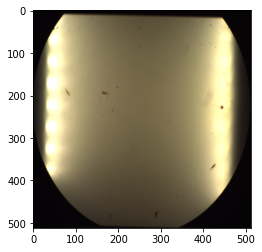

In [ ]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np


val_image_path=Path("/content/drive/MyDrive/master/data_example/RAW_val_old")

val_images = sorted(val_image_path.glob("*.bmp"))
print(len(val_images))
image = Image.open(val_images[1])


image=np.asarray(image)
print(image.shape)
dim = (512, 512)
  
# resize image
image = cv2.resize(image, dim)
plt.imshow(image)


In [ ]:
from torchvision.transforms import ToTensor
image = ToTensor()(image).unsqueeze(0)
 
image.shape

torch.Size([1, 3, 512, 512])

In [ ]:
#image=image.to(device=DEVICE)
import timeit
start = timeit.default_timer()
with torch.no_grad():
  pred = torch.sigmoid(pred_model(image))
  pred = (pred > 0.5).float()

stop = timeit.default_timer()
print('Time: ', stop - start)  

Time:  4.814203808000002


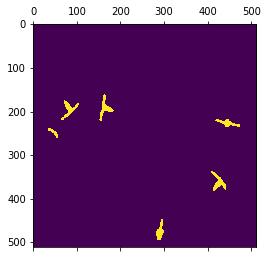

In [ ]:
pr_mask = (pred.squeeze().cpu().numpy().round())


plt.matshow(pr_mask)

Time:  0.016295205999995233
0


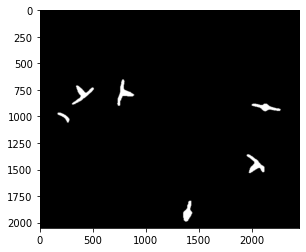

In [ ]:
dim_org=(2448,2050)
start = timeit.default_timer()
pred_org = cv2.resize(pr_mask, dim_org)
stop = timeit.default_timer()
print('Time: ', stop - start) 

print(np.argmin(pred_org))

out=Image.fromarray(pred_org*255).convert('RGB')
out.save("/content/drive/MyDrive/master/results_paper/one_manual.png")
plt.imshow(out)

In [ ]:
#All below code is for prediction

pred_model=smp.Linknet(
    encoder_name='resnet34', 
    encoder_weights='imagenet',
    classes=1, 
    activation=None
)


model_path="/content/drive/MyDrive/master/pytorch_smp/epoch_Linknet_bce7_newdata_resnet34_0.0001/Epoch_37_model.pth.tar"

temp=torch.load(model_path)
temp=temp["state_dict"]
pred_model.load_state_dict(temp)
pred_model.eval()


Linknet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [ ]:
def remove_suffix(input_string, suffix):
    if input_string.endswith(suffix):
        return input_string[:-len(suffix)]
    return input_string

In [ ]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
from torchvision.transforms import ToTensor
import os

save_dir="/content/drive/MyDrive/master/results_thesis/epoch_Linknet_bce7_newdata_resnet34_0.0001"
if not os.path.exists(save_dir):
  os.mkdir(save_dir)

val_image_path=Path("/content/drive/MyDrive/master/data_example/RAW_val_old")

val_images = sorted(val_image_path.glob("*.bmp"))
print(len(val_images))

dim_org=(2448,2050)
for img_name in val_images:

  image = Image.open(img_name)


  image=np.asarray(image)
  #print(image.shape)
  dim = (512, 512)
  # resize image
  image = cv2.resize(image, dim)

  image = ToTensor()(image).unsqueeze(0)

  with torch.no_grad():
    pred = torch.sigmoid(pred_model(image))
    pred = (pred > 0.5).float()

  pr_mask = (pred.squeeze().cpu().numpy().round())

  pred_org = cv2.resize(pr_mask, dim_org)

  out=Image.fromarray(pred_org*255).convert('RGB')

  head, tail = os.path.split(img_name)
  print(tail)
  out_name=remove_suffix(tail, ".bmp")
  out_name=out_name + "_out.png"
  img_save_path = os.path.join(save_dir, out_name)
  out.save(img_save_path)
  
 




16
D20191125T125405_728878.bmp
D20191125T125406_862891.bmp
D20191125T125407_768417.bmp
D20191125T125408_678944.bmp
D20191125T125410_525205.bmp
D20191125T125411_869320.bmp
D20191125T125413_455488.bmp
D20191125T125415_039998.bmp
D20191125T125416_400461.bmp
D20191125T125432_891139.bmp
D20191125T125434_018229.bmp
D20191125T125434_889502.bmp
D20191125T125453_637554.bmp
D20191125T125454_289695.bmp
D20191125T125455_906403.bmp
D20191125T125617_536548.bmp



/content/drive/MyDrive/master/data_example